In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control import cost_functions as cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

In [2]:
# define plot function for later convenience
def plot_singlenode(model, duration, dt, state, target, control, input, weight_array=[], M=1):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    for m in range(M-1):
        model.run()
        state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
        ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
        ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

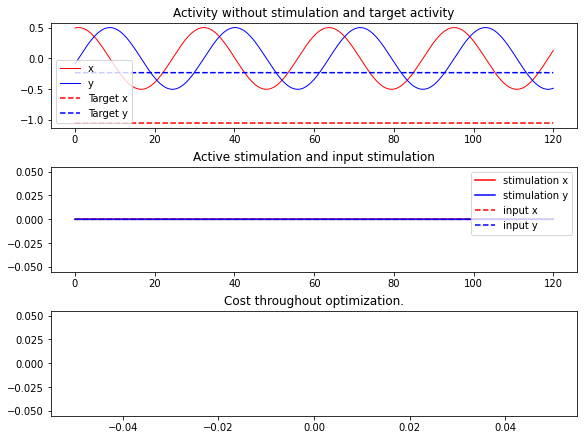

In [3]:
hopf = HopfModel()
hopf.params.sigma_ou = 0.
hopf.params.x_ou_mean = -1.

dt = hopf.params["dt"]
duration = 120.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

hopf.params["duration"] = duration
x_init = 0.
y_init = 0.
hopf.params["xs_init"] = np.array([[x_init]])
hopf.params["ys_init"] = np.array([[y_init]])
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
hopf.run()

x_init_down = np.array([[hopf.x[0,-1]]])
y_init_down = np.array([[hopf.y[0,-1]]])
hopf.params["xs_init"] = x_init_down
hopf.params["ys_init"] = y_init_down
hopf.run()

target = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

hopf.params.x_ou_mean = 0.
hopf.params["xs_init"] = np.array([[0.1]])
hopf.params["ys_init"] = np.array([[y_init]])
hopf.run()

x_init_osc = np.array([[hopf.x[0,-1]]])
y_init_osc = np.array([[hopf.y[0,-1]]])
hopf.params["xs_init"] = x_init_osc
hopf.params["ys_init"] = y_init_osc
hopf.run()

state = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

plot_singlenode(hopf, duration, dt, state, target, zero_control, zero_control)

Compute control for a deterministic system


/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'interval' of function 'precision_cost'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../neurolib/optimal_control/cost_functions.py", line 6:
@numba.njit
def precision_cost(x_target, x_sim, w_p, N, precision_matrix, interval=(0, None)):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cost in iteration 0: 95.65018134882192


/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'interval' of function 'derivative_precision_cost'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../neurolib/optimal_control/cost_functions.py", line 55:
@numba.njit
def derivative_precision_cost(x_target, x_sim, w_p, precision_matrix, interval=(0, None)):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
ERROR:root:nan in model output!
ERROR:root:nan in model output!


diverging model output, decrease step size to  5.0
Cost in iteration 1: 92.77475538050761
diverging model output, decrease step size to  2.5
Cost in iteration 2: 67.95511529068794
Cost in iteration 3: 42.25984600194657
Cost in iteration 4: 11.37120265584387
Cost in iteration 5: 6.704253846768344
Cost in iteration 6: 5.181354189060437
Cost in iteration 7: 4.073101747363475
Cost in iteration 8: 3.2373270108300507
Cost in iteration 9: 2.6236217314342056
Cost in iteration 10: 2.188118495101084
Cost in iteration 11: 1.8913172923089345
Cost in iteration 12: 1.7052101685566126
Cost in iteration 13: 1.6365225269549737
Cost in iteration 14: 1.516316444285472
Cost in iteration 15: 1.5062770536321763
Cost in iteration 16: 1.4166846852876493
Cost in iteration 17: 1.3754923638611325
Cost in iteration 18: 1.3667319977745516
Cost in iteration 19: 1.3259416449375994
Cost in iteration 20: 1.3020837447026183
Cost in iteration 21: 1.3007662447095094
Cost in iteration 22: 1.2719977010651375
Cost in iterat

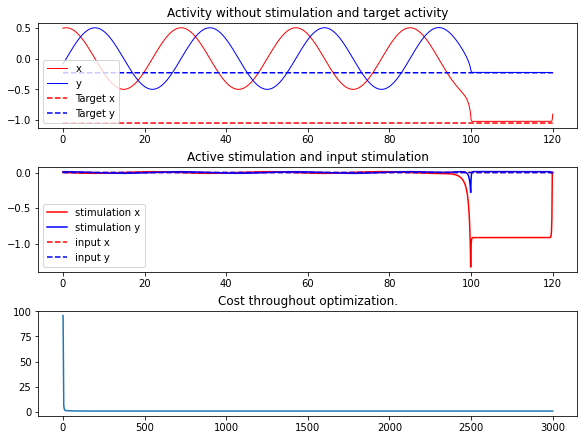

In [4]:
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
w2 = 1e-2
wp = 1.
printarray = np.concatenate( (np.arange(0,101,1), np.arange(200,1001,100), np.arange(2000,10001,1000)) )
hopf_controlled_noisefree = oc_hopf.OcHopf(hopf, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=[1000,None])

# We run 100 iterations of the optimal control gradient descent algorithm
hopf_controlled_noisefree.optimize(3000)

state = hopf_controlled_noisefree.get_xs()
control_noisefree = hopf_controlled_noisefree.control

plot_singlenode(hopf_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, hopf_controlled_noisefree.cost_history)


Compute control for a deterministic system
Cost in iteration 0: 0.9385065043445832
Cost in iteration 1: 0.9385065039464054
Cost in iteration 2: 0.9385065003986431
Cost in iteration 3: 0.9385064989570393
Cost in iteration 4: 0.9385064985213358
Cost in iteration 5: 0.938506495023315
Cost in iteration 6: 0.9385064935959038
Cost in iteration 7: 0.9385064931273394
Cost in iteration 8: 0.9385064896766079
Cost in iteration 9: 0.9385064896636063
Cost in iteration 10: 0.9385064868527564
Cost in iteration 11: 0.9385064864071343
Cost in iteration 12: 0.9385064840766699
Cost in iteration 13: 0.9385064833074441
Cost in iteration 14: 0.9385064813379561
Cost in iteration 15: 0.9385064803268058
Cost in iteration 16: 0.9385064786288319
Cost in iteration 17: 0.9385064774369786
Cost in iteration 18: 0.9385064759434786
Cost in iteration 19: 0.9385064746168384
Cost in iteration 20: 0.9385064744180888
Cost in iteration 21: 0.9385064718504361
Cost in iteration 22: 0.9385064712742642
Cost in iteration 23: 0.9

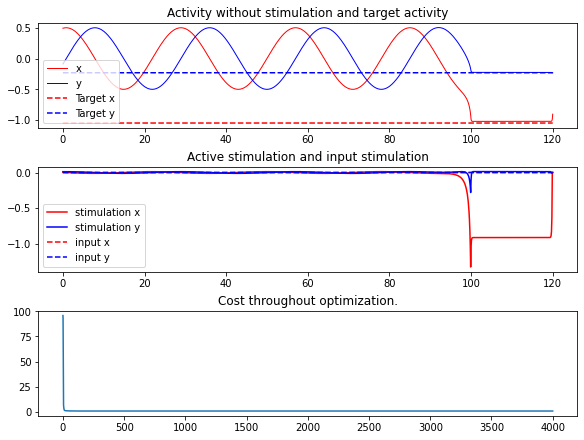

In [5]:
hopf_controlled_noisefree.optimize(1000)

state = hopf_controlled_noisefree.get_xs()
control_noisefree = hopf_controlled_noisefree.control

plot_singlenode(hopf_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, hopf_controlled_noisefree.cost_history)

In [26]:
sigma_array = [2. * 1e-2, 1. * 1e-1]
M_array = [4,20,100]

weights = np.zeros(( len(sigma_array) ))
controls = [ [None, None, None], [None, None, None]]
costs_history = controls.copy()
costs = np.zeros(( len(sigma_array), len(M_array)+1 ))

In [27]:
hopf_noise = HopfModel()
hopf_noise.params.sigma_ou = 0.
hopf_noise.params.x_ou_mean = 0.

In [28]:
hopf_noise.params.duration = 1. * 1e6
hopf_noise.params["xs_init"] = np.array([[x_init_down]])
hopf_noise.params["ys_init"] = np.array([[y_init_down]])
hopf_noise.params["x_ext"] = zero_input
hopf_noise.params["y_ext"] = zero_input

for i_s in range(len(sigma_array)):
    hopf_noise.params.sigma_ou = sigma_array[i_s]

    hopf_noise.run()
    weights[i_s] = 1. / (np.std(hopf_noise.x[0,100:]) + np.std(hopf_noise.y[0,100:]) )

print(weights)

# [45.99594752  9.07230569]

[1.39497619 1.1188955 ]


In [43]:
# controls = [ [None, None, None], [None, None, None]]

print(controls[0][0].shape, controls[0][1].shape, controls[0][2].shape)
print(controls[1][0].shape, controls[1][1].shape, controls[1][2].shape)


(1, 2, 1201) (1, 2, 1201) (1, 2, 1201)
(1, 2, 1201) (1, 2, 1201) (1, 2, 1201)


In [45]:
hopf_noise.params.duration = duration
hopf_noise.params["xs_init"] = x_init_osc
hopf_noise.params["ys_init"] = y_init_osc

hopf_noise.params.x_ou_mean = 0.
M_val = 500
max_iterations = 200
hopf_noise.run()
printarray = np.concatenate( (np.arange(0,100,10), np.arange(0,1001,100)) )

# costs_history = [ [None, None, None], [None, None, None]]

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):

        if i_m in []:
            continue

        if i_s in []:
            continue

        if type(costs_history[i_s][i_m]) != type(None):
            continue

        print("--------------------------------------------------------------")
        print("---------------------------- sigma, M = ", sigma_array[i_s], M_array[i_m])

        hopf_noise.params["x_ext"] = zero_input
        hopf_noise.params["y_ext"] = zero_input
        hopf_noise.params.sigma_ou = sigma_array[i_s]

        hopf_controlled_models = oc_hopf.OcHopf(hopf_noise, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=[1000,None],
                                    M=int(M_array[i_m]),
                                    #M = 10,
                                    M_validation=M_val, validate_per_step=True)

        # We run 100 iterations of the optimal control gradient descent algorithm
        hopf_controlled_models.optimize(max_iterations)

        state = hopf_controlled_models.get_xs()
        controls[i_s][i_m] = hopf_controlled_models.control
        costs_history[i_s][i_m] = hopf_controlled_models.cost_history
        costs[i_s][i_m+1] = hopf_controlled_models.cost_validation

        # plot_singlenode(hopf_controlled_models.model, duration, dt, state, target, controls[i_s][i_m], zero_control, hopf_controlled_models.cost_history, M=10)

--------------------------------------------------------------
---------------------------- sigma, M =  0.02 4
Compute control for a noisy system


ERROR:root:nan in model output!


Mean cost in iteration 0: 135.9227220749671
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 22.62578481886937
Mean cost in iteration 20: 5.956095308823399
Mean cost in iteration 30: 2.1537053314094377
Mean cost in iteration 40: 1.9140101564720726
Mean cost in iteration 50: 1.634304015457141
Mean cost in iteration 60: 1.5928640446939089
Mean cost in iteration 70: 1.5161652021474137
Mean cost in iteration 80: 1.426119944315824
Mean cost in iteration 90: 1.3537016925529841
Mean cost in iteration 100: 1.330195921991178
Mean cost in iteration 200: 1.1384005587364079
Minimal cost found at iteration 198
Final cost validated with 500 noise realizations : 1.1363488326643503
--------------------------------------------------------------
---------------------------- sigma, M =  0.02 20
Compute control for a noisy system


ERROR:root:nan in model output!


Mean cost in iteration 0: 136.96118039479836
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 5.866795367164487
Mean cost in iteration 20: 4.134204609696156
Mean cost in iteration 30: 3.221728806628304
Mean cost in iteration 40: 2.548472427311912
Mean cost in iteration 50: 2.144827937846589
Mean cost in iteration 60: 1.9282472993881934
Mean cost in iteration 70: 1.712144373266003
Mean cost in iteration 80: 1.5272214483869748
Mean cost in iteration 90: 1.4390154964378223
Mean cost in iteration 100: 1.3509427206557048
Mean cost in iteration 200: 1.1345410975613828
Minimal cost found at iteration 196
Final cost validated with 500 noise realizations : 1.13611101256911
--------------------------------------------------------------
---------------------------- sigma, M =  0.02 100
Compute control for a noisy system


ERROR:root:nan in model output!


Mean cost in iteration 0: 134.33141958049342
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 5.836056500540115
Mean cost in iteration 20: 4.055308270968452
Mean cost in iteration 30: 3.0840151601645855
Mean cost in iteration 40: 2.5322182313337795
Mean cost in iteration 50: 2.163078633251712
Mean cost in iteration 60: 1.855366525943026
Mean cost in iteration 70: 1.6375924075904116
Mean cost in iteration 80: 1.50943801707847
Mean cost in iteration 90: 1.398891139758503
Mean cost in iteration 100: 1.3261346072339382
Mean cost in iteration 200: 1.110674809500888
Minimal cost found at iteration 190
Final cost validated with 500 noise realizations : 1.1145732038333502
--------------------------------------------------------------
---------------------------- sigma, M =  0.1 4
Compute control for a noisy system
Mean cost in iteration 0: 157.2906175605325


ERROR:root:nan in model output!


diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 14.186644947303694
Mean cost in iteration 20: 5.091521567722363
Mean cost in iteration 30: 4.235715395077902
Mean cost in iteration 40: 4.825138545587763
Mean cost in iteration 50: 4.057598473104239
Mean cost in iteration 60: 4.46566197777792
Mean cost in iteration 70: 4.733313902682513
Mean cost in iteration 80: 3.964798106234371
Mean cost in iteration 90: 4.839369521114202
Mean cost in iteration 100: 4.674100522030857
Mean cost in iteration 200: 4.049609580160473
Minimal cost found at iteration 122
Final cost validated with 500 noise realizations : 4.034044163618563
--------------------------------------------------------------
---------------------------- sigma, M =  0.1 20
Compute control for a noisy system


ERROR:root:nan in model output!


Mean cost in iteration 0: 155.3943520690366
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 10.855587791758769
Mean cost in iteration 20: 5.241535052563372
Mean cost in iteration 30: 4.479313086559403
Mean cost in iteration 40: 4.890978383418167
Mean cost in iteration 50: 4.5427504761279405
Mean cost in iteration 60: 4.964362420956842
Mean cost in iteration 70: 4.056612280326877
Mean cost in iteration 80: 3.854056526281991
Mean cost in iteration 90: 4.1031565383085615
Mean cost in iteration 100: 3.818558144833974
Mean cost in iteration 200: 4.008537867639598
Minimal cost found at iteration 114
Final cost validated with 500 noise realizations : 3.8919733581039377
--------------------------------------------------------------
---------------------------- sigma, M =  0.1 100
Compute control for a noisy system
Mean cost in iteration 0: 157.4673184592027
Mean cost in iteration 10: 5.6234211081980385
Mean cost in iteration 20: 4.123997923997556
Mean cost in iter

In [ ]:
hopf_plot = HopfModel()
hopf_plot.params.x_ou_mean = 0.

hopf_plot.params["duration"] = duration
hopf_plot.params["xs_init"] = x_init_osc
hopf_plot.params["ys_init"] = y_init_osc


In [ ]:
for i_s in range(len(sigma_array)):

    print(i_s)

    hopf_plot.params.sigma_ou = sigma_array[i_s]

    hopf_plot.params["x_ext"] = control_noisefree[:,0,:]
    hopf_plot.params["y_ext"] = control_noisefree[:,1,:]

    cost_validation = 0.0
    energy_cost = cost_functions.energy_cost(control_noisefree, w_2=w2)

    for m in range(M_val):
        hopf_plot.run()
        state = np.concatenate((np.concatenate( (hopf_plot.params["xs_init"], hopf_plot.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf_plot.x, hopf_plot.y), axis=1)), axis=2)
        precision_cost = cost_functions.precision_cost(target, state, wp, 1, np.ones( (1, 2)), [1000,-1])
        cost_validation += precision_cost + energy_cost

    costs[i_s][0] = cost_validation/M_val

print(costs[0][0], costs[1][0])

0
1
1.5948765139855652 5.571471895392811


0 0 (1, 2, 1201)
1 0 (1, 2, 1201)
2 0 (1, 2, 1201)
0 1 (1, 2, 1201)
1 1 (1, 2, 1201)
2 1 (1, 2, 1201)


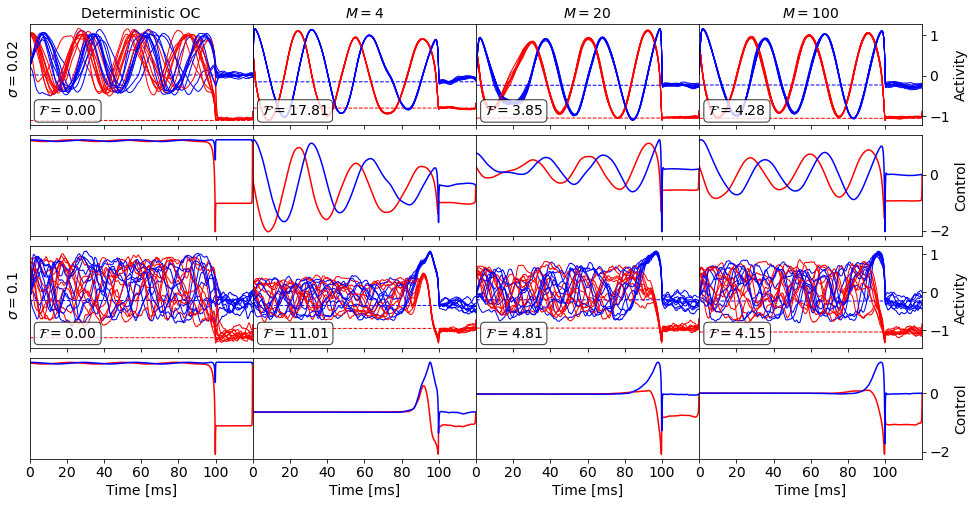

In [ ]:
row, col = int(2*len(sigma_array)), int(len(M_array)+1)

fig = plt.figure(figsize=(4*col,2*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')
box_props = dict(boxstyle='round', facecolor='white', alpha=0.8)
fs = 14
savepath = '..' + os.sep + '..' + os.sep + '..' + os.sep + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + '2022_Wittenberg' + os.sep + 'talk' + os.sep + 'talk' + os.sep + 'images'

time_array = np.arange(0, duration+dt, dt)

for i_s in range(len(sigma_array)):
    ax[2*i_s, 0].text(-0.1, 0.3, r'$\sigma = $'+ "{}".format(sigma_array[i_s]),
    transform=ax[2*i_s, 0].transAxes, rotation='vertical', fontsize=fs)

    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,0,:], color=color_x)
    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,1,:], color=color_y)
    
    hopf_plot.params.sigma_ou = sigma_array[i_s]

    hopf_plot.params["x_ext"] = control_noisefree[:,0,:]
    hopf_plot.params["y_ext"] = control_noisefree[:,1,:]

    ax[2*i_s, 0].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
    ax[2*i_s, 0].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

    for m in range(10):
        hopf_plot.run()
        ax[2*i_s, 0].plot(time_array[1:], hopf_plot.x[0,:], color=color_x, linewidth=1)
        ax[2*i_s, 0].plot(time_array[1:], hopf_plot.y[0,:], color=color_y, linewidth=1)

    ax[2*i_s, 0].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][0]),
        transform=ax[2*i_s, 0].transAxes, fontsize=fs, bbox=box_props)

    for i_m in range(len(M_array)):
        print(i_m, i_s, controls[i_s][i_m].shape)
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,0,:], color=color_x)
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,1,:], color=color_y)

        ax[2*i_s, i_m+1].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][i_m+1]),
        transform=ax[2*i_s, i_m+1].transAxes, fontsize=fs, bbox=box_props)

        hopf_plot.params["x_ext"] = controls[i_s][i_m][:,0,:]
        hopf_plot.params["y_ext"] = controls[i_s][i_m][:,1,:]

        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

        for m in range(10):
            hopf_plot.run()
            ax[2*i_s, i_m+1].plot(time_array[1:], hopf_plot.x[0,:], color=color_x, linewidth=1)
            ax[2*i_s, i_m+1].plot(time_array[1:], hopf_plot.y[0,:], color=color_y, linewidth=1)



    for k in range(col-1):
        ax[2*i_s,k].set_yticks([])
        ax[2*i_s+1,k].set_yticks([])
    
    ax[2*i_s,-1].yaxis.tick_right()
    ax[2*i_s+1,-1].yaxis.tick_right()

    ax[2*i_s,-1].set_ylabel("Activity", fontsize=fs)
    ax[2*i_s,-1].yaxis.set_label_position("right")
    ax[2*i_s+1,-1].set_ylabel("Control", fontsize=fs)
    ax[2*i_s+1,-1].yaxis.set_label_position("right")


for k in range(col):
    for j in range(row-1):
        ax[j,k].set_xticks([])
        ax[j,k].set_xlim([0,duration])
        ax[j,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xticks(np.arange(0,120,20))
    ax[-1,k].set_xlim([0,duration])
    ax[-1,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xlabel("Time [ms]", fontsize=fs)

for i_m in range(len(M_array)):
    ax[0,i_m+1].set_title(r"$M=$" + "{}".format(M_array[i_m]), fontsize=fs)

ax[0,0].set_title(r"Deterministic OC", fontsize=fs)

fig.savefig(os.path.join(savepath, 'Hopf_osc_down_traces.jpg'), bbox_inches='tight')
plt.show()


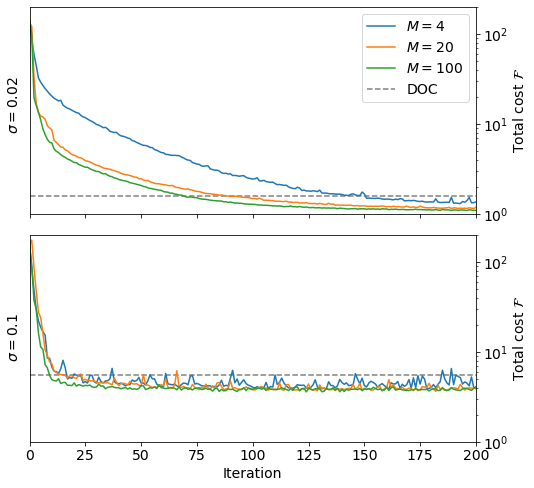

In [ ]:
row, col = len(sigma_array), 1

fig = plt.figure(figsize=(8,4*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):
        ax[i_s].plot(costs_history[i_s][i_m], label=r'$M=$' + '{}'.format(M_array[i_m]))

    ax[i_s].hlines(costs[i_s,0], 0, max_iterations, label='DOC', linestyle='--', color='grey')

    ax[i_s].text(-0.05, 0.4, r'$\sigma = $'+ "{}".format(sigma_array[i_s]), transform=ax[i_s].transAxes, rotation='vertical', fontsize=fs)

    ax[i_s].set_ylabel(r'Total cost $\mathcal{F}$', fontsize=fs)
    ax[i_s].yaxis.set_label_position("right")
    ax[i_s].yaxis.tick_right()
    ax[i_s].tick_params(axis='both', labelsize=fs)
    ax[i_s].set_xlim([0,max_iterations])
    ax[i_s].set_yscale('log')
    ax[i_s].set_ylim(1., max_iterations)

ax[0].legend(loc='upper right', fontsize=fs)
ax[-1].set_xlabel("Iteration", fontsize=fs)


fig.savefig(os.path.join(savepath, 'Hopf_osc_down_cost.jpg'), bbox_inches='tight')
plt.show()